In [24]:
from autograd import numpy as np
from autograd import grad
from tqdm import tqdm

def MALA(x0, log_prob_fun, grad_log_prob_fun, n_steps=100, stepsize=0.01):
    """

    Parameters
    ----------
    x0 : array of floats
        initial configuration
    log_prob_fun : callable, accepts an array and returns a float
        unnormalized log probability density function
    grad_log_prob_fun : callable, accepts an array and returns an array
        gradient of log_prob_fun
    n_steps : integer
        number of Langevin steps
    stepsize : float > 0
        finite timestep parameter
    collision_rate : float > 0
        controls the rate of interaction with the heat bath

    Returns
    -------
    traj : [n_steps + 1 x dim] array of floats
        trajectory of samples generated by Metropolis-Adjusted Langevin dynamics
    log_probs : [n_steps + 1] array of floats
        unnormalized log-probabilities of the samples
    grads : [n_steps + 1 x dim] array of floats
        trajectory of gradients of the log probability density at the samples generated by Langevin dynamics
    acceptance_probs : [n_steps] array of floats
        acceptance probabilities for the proposals
    """
    
    traj = [np.array(x0)]
    log_probs = [log_prob_fun(traj[-1])]
    grad_log_prob = grad(log_prob_fun)
    grads = [grad_log_prob(traj[-1])]
    acceptance_probs = []
    
    sigma = np.sqrt(2 * stepsize)
    
    def proposal_log_probability(proposal, initial, grad_initial):
        return (-1 / (4 * stepsize)) * np.sum((proposal - initial - stepsize * grad_initial)**2)

    trange = tqdm(range(n_steps))
    for t in trange:
        proposal = traj[-1] + (stepsize * grads[-1]) + (sigma * np.random.randn(*traj[-1].shape))
        log_prob_proposal = log_prob_fun(proposal)
        grad_proposal = grad_log_prob(proposal)
        
        log_prob_ratio = log_prob_proposal - log_probs[-1]
        if not np.isfinite(log_prob_proposal):
            acceptance_prob = 0
        else:
            log_forward_proposal_probability = proposal_log_probability(proposal, traj[-1], grads[-1])
            log_reverse_proposal_probability = proposal_log_probability(traj[-1], proposal, grad_proposal)

            log_acceptance_probability = min(0, log_prob_ratio + log_reverse_proposal_probability - log_forward_proposal_probability)
            acceptance_prob = np.exp(log_acceptance_probability)
        acceptance_probs.append(acceptance_prob)
        
        if np.random.rand() < acceptance_prob:
            traj.append(proposal)
            log_probs.append(log_prob_proposal)
            grads.append(grad_proposal)
        else:
            traj.append(traj[-1])
            log_probs.append(log_probs[-1])
            grads.append(grads[-1])
        
        trange.set_postfix({
            'log_prob': log_probs[-1],
            'average_accept_prob': np.mean(acceptance_probs),
        })
        
        if t % 100 == 0:
            if np.mean(acceptance_probs) < 0.1 or np.mean(acceptance_probs) > 0.9:
                print('Acceptance rate so far ({}) is not close to the optimal acceptance rate (0.574). Consider adjusting the step-size.'.format(np.mean(acceptance_probs)))
        
    return np.array(traj), np.array(log_probs), np.array(grads), np.array(acceptance_probs)

In [25]:
def log_prob(x):
    return - np.sum(x**4)

In [26]:
log_prob(np.ones(2))

-2.0

In [27]:
grad(log_prob)(np.ones(2))

array([-4., -4.])

In [28]:
x0 = np.ones(2)

In [37]:
traj, log_probs, grads, acceptance_probs = MALA(x0, log_prob, n_steps=10000, stepsize=0.3)

  1%|          | 95/10000 [00:00<00:21, 469.37it/s, log_prob=-0.546, average_accept_prob=0.545]  

Acceptance rate so far (1.0) is not close to the optimal acceptance rate (0.574). Consider adjusting the step-size.


100%|██████████| 10000/10000 [00:25<00:00, 388.44it/s, log_prob=-0.101, average_accept_prob=0.61]   


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

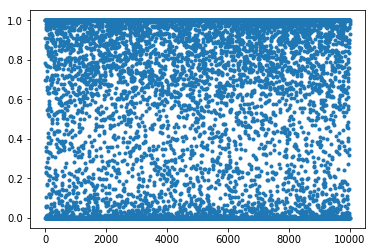

In [41]:
plt.plot(acceptance_probs, '.')

/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(0, 1)

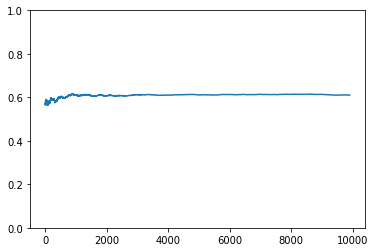

In [49]:
plt.plot((np.cumsum(acceptance_probs) / np.arange(len(acceptance_probs)))[100:])
plt.ylim(0,1)

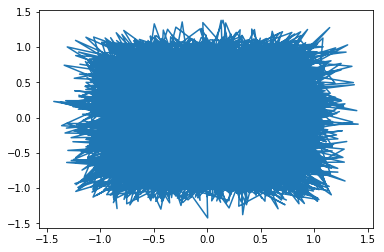

In [43]:
plt.plot(traj[:,0], traj[:,1])

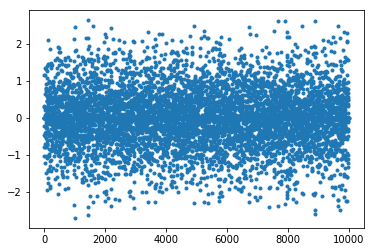

In [47]:
plt.plot(np.diff(traj[:,0]), '.')

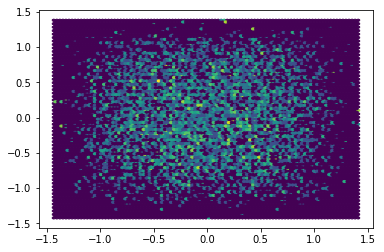

In [52]:
plt.hexbin(traj[:,0], traj[:,1], bins='log')

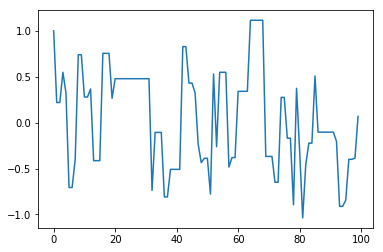

In [54]:
plt.plot(traj[:100,0])